In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import shutil
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import lite, keras
from tensorflow.keras import layers, backend
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, 
    Add, GlobalAveragePooling2D, Dense, Dropout, Flatten
)
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy, categorical_accuracy
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator, array_to_img, img_to_array, load_img
)
from tensorflow.keras.callbacks import CSVLogger


In [2]:
os.listdir('../Data/')

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [3]:
base_dir = "../Data/"
image_paths = []
classes = []
for class_folder in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_folder)
    
    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, image_file))
            classes.append(class_folder)

df = pd.DataFrame({'image': image_paths, 'class': classes})
df.head()

,image,class
0,../Data/cataract\0_left.jpg,cataract
1,../Data/cataract\103_left.jpg,cataract
2,../Data/cataract\1062_right.jpg,cataract
3,../Data/cataract\1083_left.jpg,cataract
4,../Data/cataract\1084_right.jpg,cataract


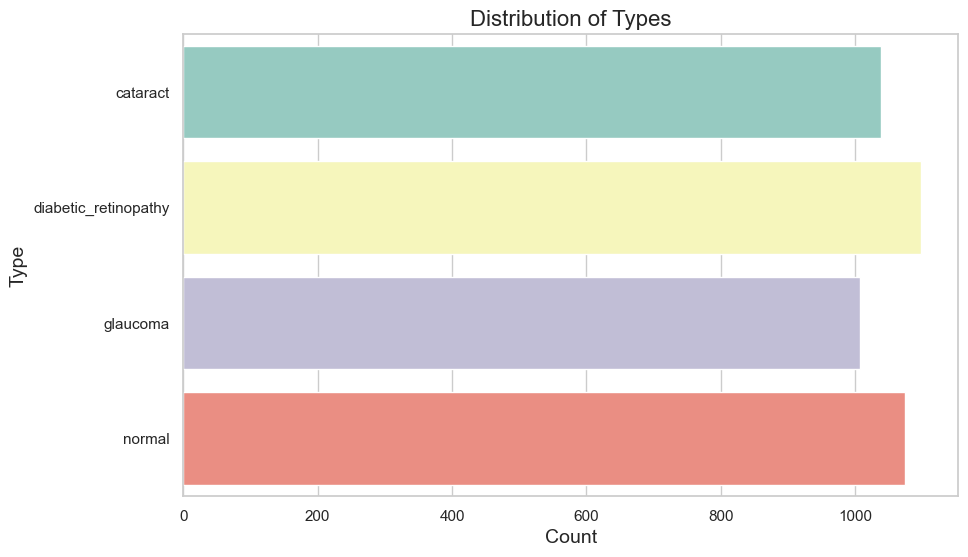

In [4]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(y='class', data=df, hue='class', palette="Set3")
plt.title('Distribution of Types', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Type', fontsize=14)
plt.show()

In [5]:
train, remain = train_test_split(df, train_size=0.8, stratify=df['class'], random_state=0)

In [6]:
test, valid = train_test_split(remain, train_size=0.5, stratify=remain['class'], random_state=0)

In [7]:
height = 512
width = 512
channels = 3
batch_size = 8
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test)

test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

def scalar(img):
    img=img/255
    return img 

trgen=ImageDataGenerator(preprocessing_function=scalar, 
                         horizontal_flip=True, 
                         vertical_flip = True,
                         )
tvgen=ImageDataGenerator(preprocessing_function=scalar)


test_gen=tvgen.flow_from_dataframe( 
    test, 
    x_col='image', 
    y_col='class', 
    target_size=img_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=False, 
    batch_size=test_batch_size)

train_gen = trgen.flow_from_dataframe(
        train,
        x_col='image',
        y_col='class',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True,
        batch_size=batch_size
    )

valid_gen = tvgen.flow_from_dataframe(
        valid,
        x_col='image',
        y_col='class',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True,
        batch_size=batch_size
    )

test batch size:  2   test steps:  211
Found 422 validated image filenames belonging to 4 classes.


Found 3373 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.


In [8]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='green', fontsize=16)
        plt.axis('off')
    plt.show()

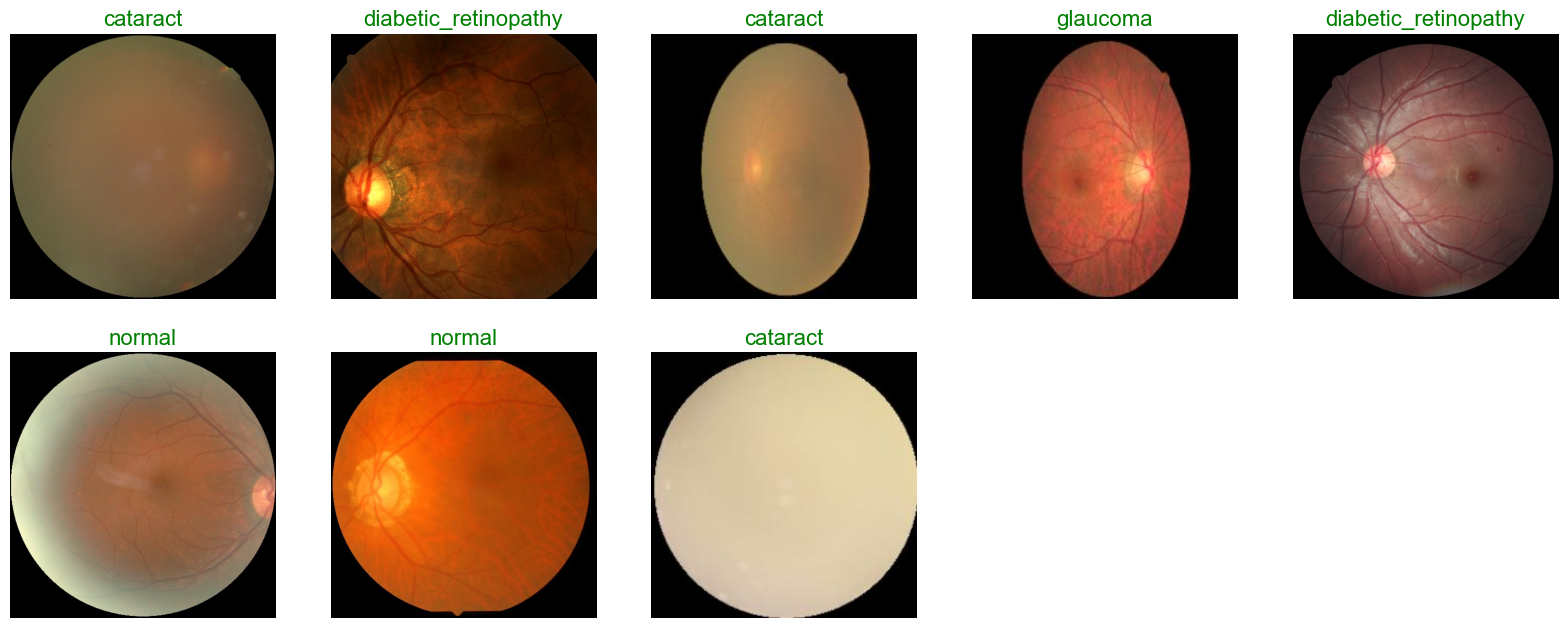

In [9]:
show_image_samples(train_gen)

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-9)
early_stop = EarlyStopping(monitor='val_loss', patience=13, restore_best_weights=True)
callbacks = [reduce_lr, early_stop]

In [11]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key            
    classes=list(new_dict.values())     
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  
        if pred_index != true_index: 
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))              
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) 
                plot_class.append(value)   
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # Create a confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        length = len(classes)
        if length < 8:
            fig_width = 8
            fig_height = 8
        else:
            fig_width = int(length * 0.5)
            fig_height = int(length * 0.5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [12]:
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D,GlobalMaxPooling2D, Dense, Dropout, Activation, Reshape, Multiply, MaxPooling2D, Add, Concatenate, DepthwiseConv2D, BatchNormalization
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import regularizers

def cbam_block(input_feature, ratio=8, l2_reg=0.01):
    # Channel attention
    channel_avg = GlobalAveragePooling2D()(input_feature)
    channel_max = GlobalMaxPooling2D()(input_feature)
    channel_concat = Concatenate()([channel_avg, channel_max])
    channel_dense_1 = Dense(units=tf.keras.backend.int_shape(input_feature)[-1] // ratio, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(channel_concat)
    channel_dense_2 = Dense(units=tf.keras.backend.int_shape(input_feature)[-1], activation='sigmoid', kernel_regularizer=regularizers.l2(l2_reg))(channel_dense_1)
    channel_attention = Reshape((1, 1, -1))(channel_dense_2)
    channel_multiply = Multiply()([input_feature, channel_attention])

    spatial_avg = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(input_feature)
    spatial_max = tf.keras.layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(input_feature)
    spatial_concat = Concatenate()([spatial_avg, spatial_max])
    spatial_conv = Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='sigmoid', kernel_regularizer=regularizers.l2(l2_reg))(spatial_concat)
    spatial_attention = Multiply()([input_feature, spatial_conv])

    cbam_feature = Add()([channel_multiply, spatial_attention])
    return cbam_feature

def create_model_with_cbam_and_skip(img_shape=(512, 512, 3), l2_reg=0.1):
    input_tensor = Input(shape=img_shape)

    base_model = tf.keras.applications.MobileNet(
        include_top=False,
        weights='imagenet', 
        input_tensor=input_tensor,  
        alpha=0.25
    )
    
    x = input_tensor
    for layer in base_model.layers[1:]: 
        x = layer(x)
        if isinstance(layer, DepthwiseConv2D):
            x = cbam_block(x, l2_reg=l2_reg)

    base = BatchNormalization()(x)
    base = MaxPooling2D(pool_size=(2,2))(base)
   

    x = cbam_block(base, l2_reg=l2_reg) 
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = Dropout(rate=0.3, seed=0)(x)
    output = Dense(4, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=output)

    return model

model = create_model_with_cbam_and_skip(l2_reg=0.16)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 256, 256, 8)  216         ['input_1[0][0]']                
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 256, 256, 8)  32          ['conv1[1][0]']                  
                                                                                                  
 conv1_relu (ReLU)              (None, 256, 256, 8)  0           ['conv1_bn[1][0]']           

In [13]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy',tf.keras.metrics.AUC()])

In [14]:
model.save('temp_model.h5')

In [15]:
epochs = 120
train_step = int(train_gen.samples/batch_size)
valid_step = int(valid_gen.samples/batch_size)

history = model.fit(
    x=train_gen,
    epochs=epochs,
    steps_per_epoch=train_step,  
    batch_size = batch_size,
    verbose=1,
    callbacks=callbacks,
    validation_data=valid_gen,
    validation_steps=valid_step,
    initial_epoch=0
)

Epoch 1/120
421/421 [==============================] - 50s 102ms/step - loss: 8.9658 - accuracy: 0.5780 - auc: 0.8316 - val_loss: 7.4497 - val_accuracy: 0.6707 - val_auc: 0.8913 - lr: 1.0000e-04
Epoch 2/120
421/421 [==============================] - 40s 96ms/step - loss: 6.4430 - accuracy: 0.7135 - auc: 0.9135 - val_loss: 5.5794 - val_accuracy: 0.7596 - val_auc: 0.9321 - lr: 1.0000e-04
Epoch 3/120
421/421 [==============================] - 42s 99ms/step - loss: 5.0091 - accuracy: 0.7569 - auc: 0.9336 - val_loss: 4.4305 - val_accuracy: 0.7861 - val_auc: 0.9527 - lr: 1.0000e-04
Epoch 4/120
421/421 [==============================] - 43s 102ms/step - loss: 4.0855 - accuracy: 0.7860 - auc: 0.9471 - val_loss: 3.6494 - val_accuracy: 0.8197 - val_auc: 0.9661 - lr: 1.0000e-04
Epoch 5/120
421/421 [==============================] - 43s 102ms/step - loss: 3.4495 - accuracy: 0.8062 - auc: 0.9574 - val_loss: 3.1480 - val_accuracy: 0.8173 - val_auc: 0.9675 - lr: 1.0000e-04
Epoch 6/120
421/421 [======

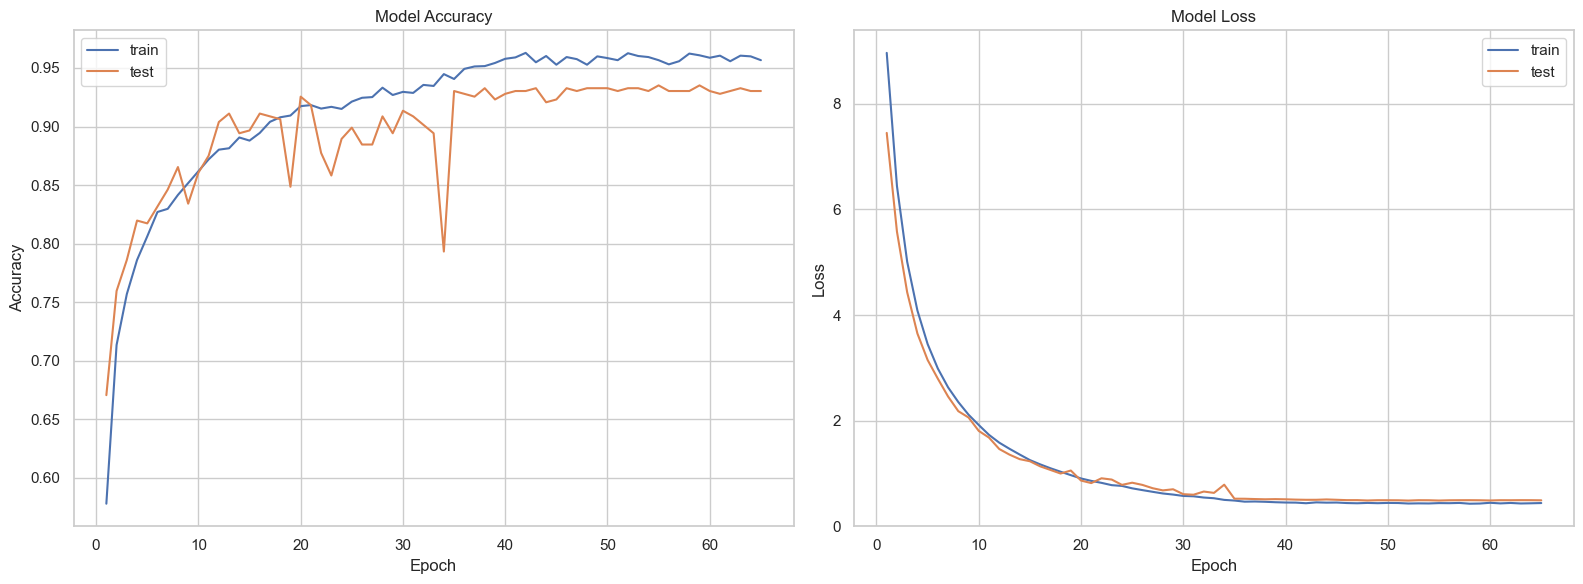

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
####################################
sns.set(style='whitegrid')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.lineplot(x=range(1, len(history.history['accuracy']) + 1), y=history.history['accuracy'], ax=axes[0], label='train')   
sns.lineplot(x=range(1, len(history.history['val_accuracy']) + 1), y=history.history['val_accuracy'], ax=axes[0], label='test')
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(loc='upper left')

sns.lineplot(x=range(1, len(history.history['loss']) + 1), y=history.history['loss'], ax=axes[1], label='train')
sns.lineplot(x=range(1, len(history.history['val_loss']) + 1), y=history.history['val_loss'], ax=axes[1], label='test')
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(loc='upper right')
plt.tight_layout()
plt.show()
####################################

211/211 [==============================] - 4s 19ms/step
Classification Report:
----------------------
                       precision    recall  f1-score   support

            cataract       0.93      0.96      0.94       104
diabetic_retinopathy       1.00      0.98      0.99       110
            glaucoma       0.91      0.83      0.87       100
              normal       0.88      0.94      0.91       108

            accuracy                           0.93       422
           macro avg       0.93      0.93      0.93       422
        weighted avg       0.93      0.93      0.93       422



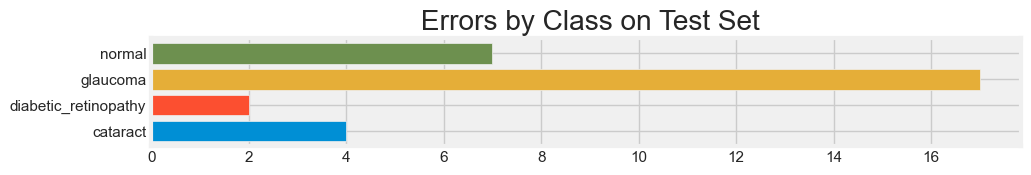

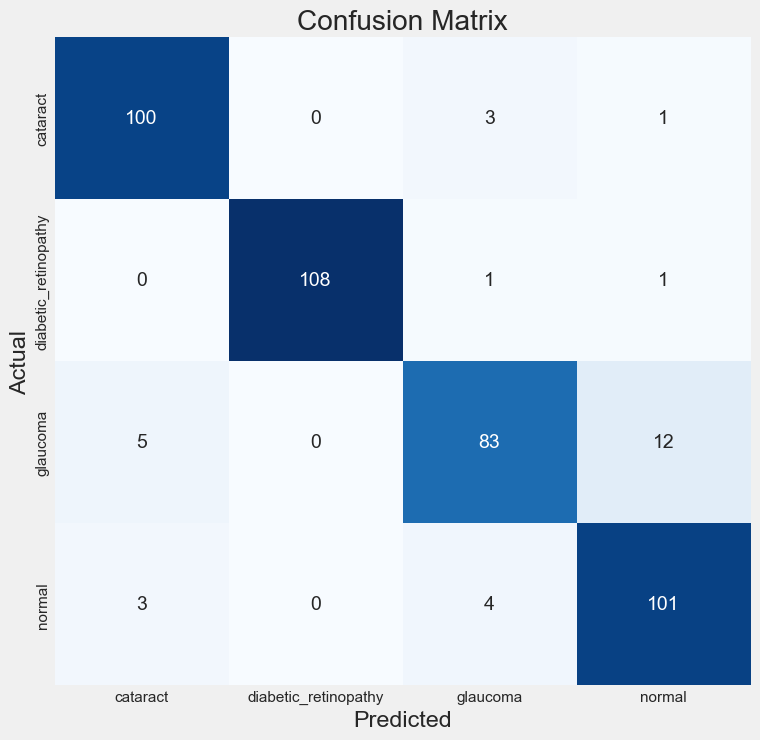

In [20]:
pred = model.predict(test_gen)
print_code = 0
save_dir = "./"
subject='classes'
print_info( test_gen, pred, print_code, save_dir, subject)

211/211 [==============================] - 4s 19ms/step


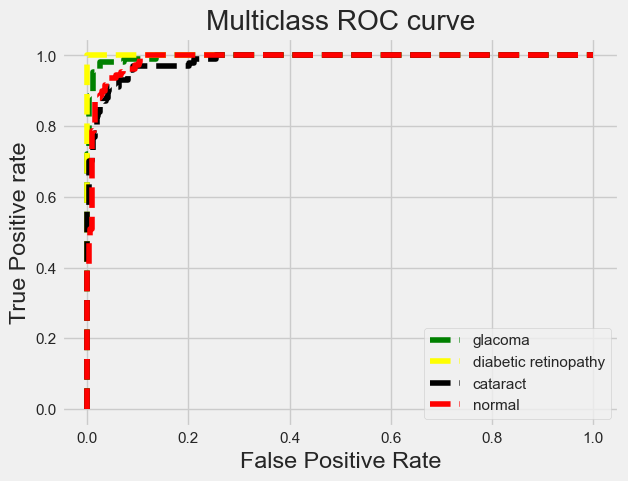

In [21]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

pred_prob = model.predict(test_gen)

fpr = {}
tpr = {}
thresh ={}

n_class = 4

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(test_gen.classes, pred_prob[:,i], pos_label=i)


plt.plot(fpr[0], tpr[0], linestyle='--',color='green', label='glacoma')
plt.plot(fpr[1], tpr[1], linestyle='--',color='yellow', label='diabetic retinopathy')
plt.plot(fpr[2], tpr[2], linestyle='--',color='black', label='cataract')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='normal')


plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')